# Random Forest Wave Estimation

### Packages

In [9]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Data Processing

In [10]:
filepath_train_2021 = '44014_2021.txt'
filepath_train_2022 = '44014_2022.txt'
filepath_train_2023 = '44014_2023.txt'
filepath_test_2024 = '44014_2024.txt'

# Define column names once
colnames = ["YY","MM","DD","hh","mm","WDIR","WSPD","GST","WVHT","DPD","APD","MWD",
            "PRES","ATMP","WTMP","DEWP","VIS","TIDE"]

# Load all training years
data_2021 = pd.read_csv(filepath_train_2021, sep=r'\s+', comment='#', header=None)
data_2022 = pd.read_csv(filepath_train_2022, sep=r'\s+', comment='#', header=None)
data_2023 = pd.read_csv(filepath_train_2023, sep=r'\s+', comment='#', header=None)

for df in [data_2021, data_2022, data_2023]:
    df.columns = colnames
    # Replace missing values
    df.replace({99.00: np.nan, 99.0: np.nan, 999: np.nan, 999.0: np.nan}, inplace=True)
    # Drop rows without wave height
    df.dropna(subset=["WVHT"], inplace=True)
    # Interpolate
    df.interpolate(inplace=True)
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    # Datetime
    df["datetime"] = pd.to_datetime(
        df[['YY','MM','DD','hh','mm']].rename(
            columns={'YY':'year','MM':'month','DD':'day','hh':'hour','mm':'minute'}
        )
    )
    df.drop(columns=["YY","MM","DD","hh","mm","VIS","TIDE"], inplace=True)
    # Cyclical features
    df["hour_sin"] = np.sin(2*np.pi*df["datetime"].dt.hour / 24)
    df["hour_cos"] = np.cos(2*np.pi*df["datetime"].dt.hour / 24)
    df["doy_sin"]  = np.sin(2*np.pi*df["datetime"].dt.dayofyear / 365)
    df["doy_cos"]  = np.cos(2*np.pi*df["datetime"].dt.dayofyear / 365)
    df.drop(columns=["datetime"], inplace=True)

data_train = pd.concat([data_2021, data_2022, data_2023], ignore_index=True)
data_test = pd.read_csv(filepath_test_2024, sep=r'\s+', comment='#', header=None)
data_test.columns = colnames

# Replace missing values with NaNs
data_train= data_train.replace({99.00: np.nan, 99.0: np.nan, 999: np.nan, 999.0: np.nan})
data_test= data_test.replace({99.00: np.nan, 99.0: np.nan, 999: np.nan, 999.0: np.nan})
# Drop rows without wave height
data_train= data_train.dropna(subset=["WVHT"])
data_test= data_test.dropna(subset=["WVHT"])
# Interpolate to fill in any remaining NaNs
data_train= data_train.interpolate().bfill().ffill()
data_test= data_test.interpolate().bfill().ffill()

data_test["datetime"]= pd.to_datetime(data_test[['YY','MM','DD','hh','mm']].rename(columns=
        {'YY':'year','MM':'month','DD':'day','hh':'hour','mm':'minute'}))
data_test= data_test.drop(columns=["YY","MM","DD","hh","mm","VIS","TIDE"])

data_test["hour_sin"] = np.sin(2*np.pi*data_test["datetime"].dt.hour / 24)
data_test["hour_cos"] = np.cos(2*np.pi*data_test["datetime"].dt.hour / 24)
data_test["doy_sin"]  = np.sin(2*np.pi*data_test["datetime"].dt.dayofyear / 365)
data_test["doy_cos"]  = np.cos(2*np.pi*data_test["datetime"].dt.dayofyear / 365)
data_test= data_test.drop(columns=["datetime"])

Featurs to Use:
WSPD
GST
WDIR
PRES
ATMP
WTMP
DEWP
hour_sin
Hour_cos
doy_sin
doy_cos

Exclude:
DPD
MWD
APD

Target
WVHT

In [11]:
features = ["WSPD","GST","WDIR","PRES","ATMP","WTMP","DEWP",
            "hour_sin","hour_cos","doy_sin","doy_cos"]

X_train = data_train[features].values
y_train = data_train["WVHT"].values.reshape(-1, 1)

X_test = data_test[features].values
y_test = data_test["WVHT"].values.reshape(-1, 1)

# --- Normalize using scalers fit on training data ---
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)   # transform with same scaler

y_scaler = StandardScaler()
y_train_scaled = y_train#y_scaler.fit_transform(y_train)
y_test_scaled  = y_test#y_scaler.transform(y_test)   # transform with same scaler

# Wrap back into pandas for consistency
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
y_train_series = pd.Series(y_train_scaled.flatten(), name="WVHT")

X_test_df = pd.DataFrame(X_test_scaled, columns=features)
y_test_series = pd.Series(y_test_scaled.flatten(), name="WVHT")

In [12]:
def create_window(x, y, time_steps=72):
    x_window, y_window = [], []
    for i in range(len(x) - time_steps):
        x_window.append(x.iloc[i:(i+time_steps)].values)
        y_window.append(y.iloc[i+time_steps])
    return np.array(x_window), np.array(y_window)

X_train_window, y_train_window = create_window(X_train_df, y_train_series, time_steps=72)
X_test_window, y_test_window   = create_window(X_test_df, y_test_series, time_steps=72)

### The Random Forest Model

In [13]:
# Flatten windowed data
X_train = X_train_window.reshape(X_train_window.shape[0], -1)
y_train = y_train_window
X_test = X_test_window.reshape(X_test_window.shape[0], -1)
y_test = y_test_window

RFmodel = RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', bootstrap=True, oob_score=True, random_state=42, n_jobs=-1)
RFmodel.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

Overall RMSE: 0.4078
Mean Absolute Error (MAE): 0.2990
R² Score: 0.6990


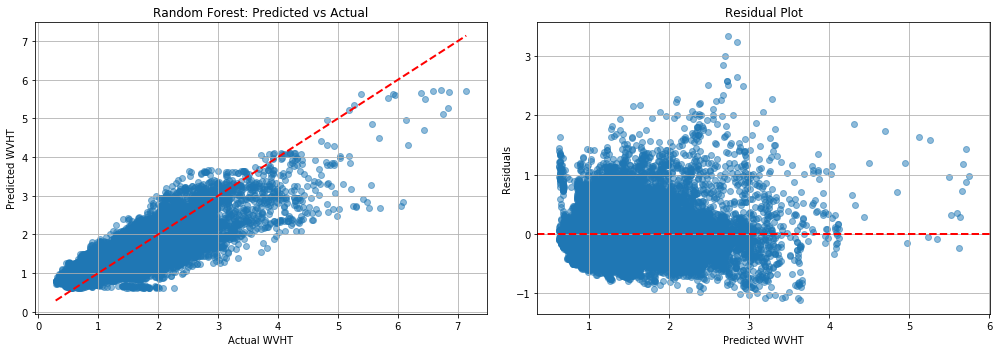

In [14]:
y_pred = RFmodel.predict(X_test)

# Calculate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Overall RMSE: {overall_rmse:.4f}")

# Additional metrics
mae = np.mean(np.abs(y_test - y_pred))
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# R² score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual WVHT')
plt.ylabel('Predicted WVHT')
plt.title('Random Forest: Predicted vs Actual')
plt.grid(True)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted WVHT')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

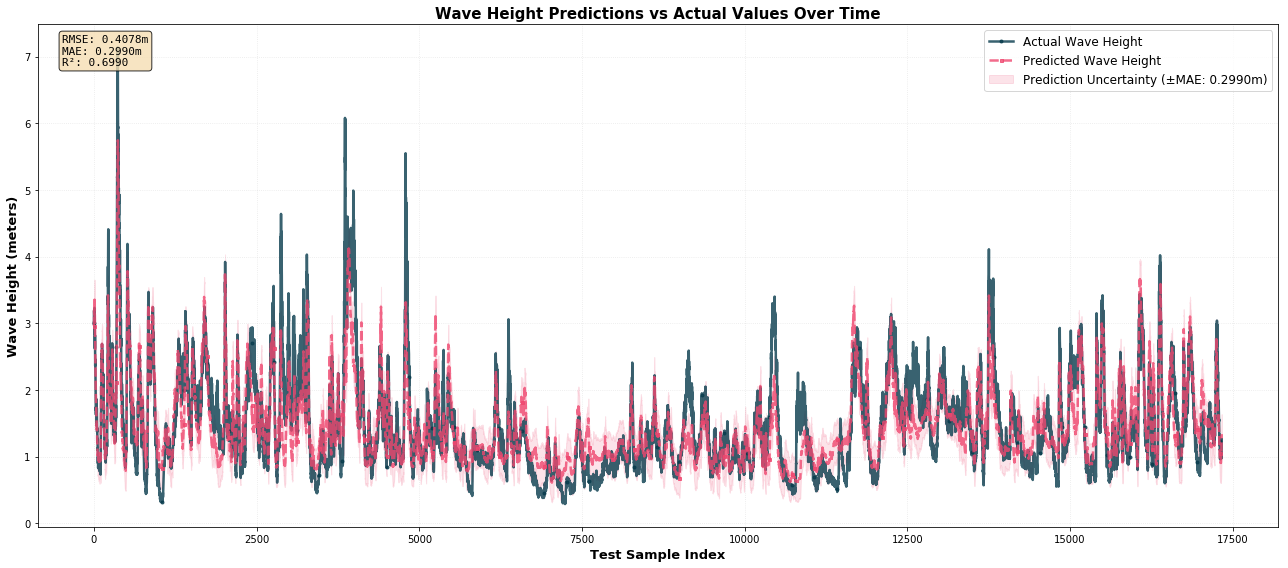

Time series plot saved as 'time_series_predictions.png'


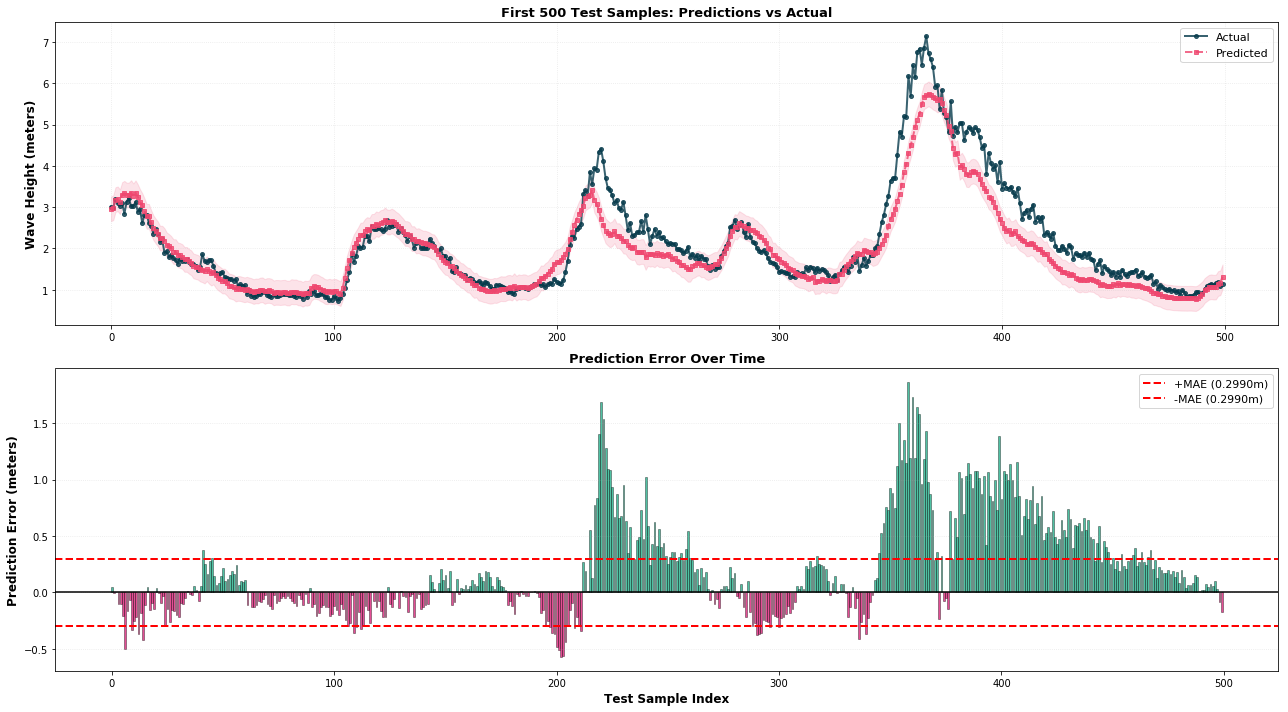

Zoomed plot saved as 'zoomed_predictions_and_errors.png'


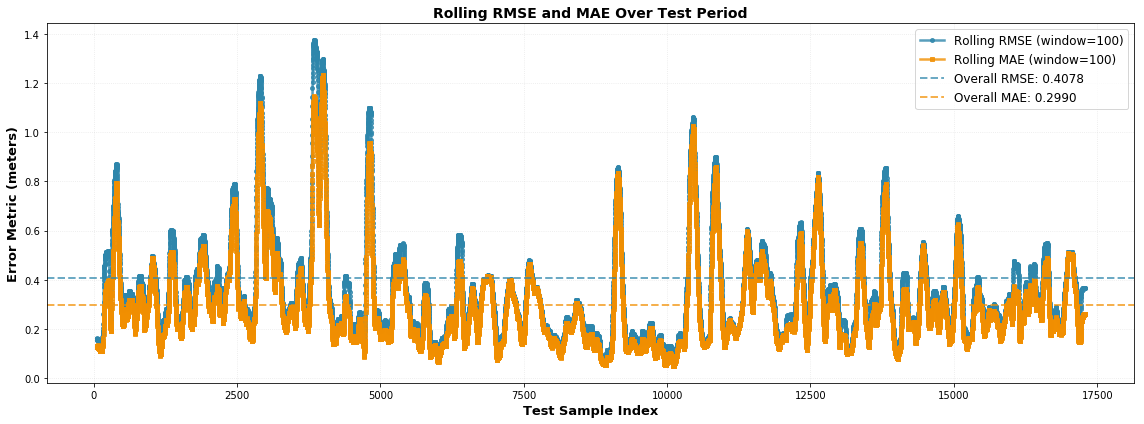

Rolling metrics plot saved as 'rolling_metrics.png'

Rolling Statistics Summary:
  - Mean rolling RMSE: 0.3494m
  - Min rolling RMSE: 0.0638m
  - Max rolling RMSE: 1.3757m
  - Mean rolling MAE: 0.2997m
  - Min rolling MAE: 0.0483m
  - Max rolling MAE: 1.2311m


In [15]:
# TIME SERIES PLOT: PREDICTIONS VS ACTUAL OVER TIME

# Create time index for test set
test_time_index = np.arange(len(y_test))

fig, ax = plt.subplots(figsize=(18, 8))

# Plot actual values
ax.plot(test_time_index, y_test.flatten(), label='Actual Wave Height', 
        linewidth=2.5, color='#073B4C', marker='o', markersize=3, 
        markevery=max(1, len(y_test)//50), alpha=0.8)

# Plot predicted values
ax.plot(test_time_index, y_pred, label='Predicted Wave Height', 
        linewidth=2.5, color='#EF476F', linestyle='--', marker='s', 
        markersize=3, markevery=max(1, len(y_test)//50), alpha=0.8)

# Add confidence band (±MAE)
ax.fill_between(test_time_index, y_pred - mae, y_pred + mae, 
                alpha=0.15, color='#EF476F', label=f'Prediction Uncertainty (±MAE: {mae:.4f}m)')

# Formatting
ax.set_xlabel('Test Sample Index', fontsize=13, fontweight='bold')
ax.set_ylabel('Wave Height (meters)', fontsize=13, fontweight='bold')
ax.set_title('Wave Height Predictions vs Actual Values Over Time', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3, linestyle=':')

# Add statistics box
textstr = f'RMSE: {overall_rmse:.4f}m\nMAE: {mae:.4f}m\nR²: {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('time_series_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Time series plot saved as 'time_series_predictions.png'")

# Zoomed in view
zoom_length = min(500, len(y_test))

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Full time series (top)
axes[0].plot(test_time_index[:zoom_length], y_test[:zoom_length].flatten(), 
            label='Actual', linewidth=2, color='#073B4C', marker='o', markersize=4, alpha=0.8)
axes[0].plot(test_time_index[:zoom_length], y_pred[:zoom_length], 
            label='Predicted', linewidth=2, color='#EF476F', linestyle='--', marker='s', markersize=4, alpha=0.8)
axes[0].fill_between(test_time_index[:zoom_length], 
                     y_pred[:zoom_length] - mae, 
                     y_pred[:zoom_length] + mae, 
                     alpha=0.15, color='#EF476F')
axes[0].set_ylabel('Wave Height (meters)', fontsize=12, fontweight='bold')
axes[0].set_title(f'First {zoom_length} Test Samples: Predictions vs Actual', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle=':')

# Error over time (bottom)
errors_zoomed = y_test[:zoom_length].flatten() - y_pred[:zoom_length]
axes[1].bar(test_time_index[:zoom_length], errors_zoomed, 
           color=['#06A77D' if e >= 0 else '#D90368' for e in errors_zoomed],
           alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1.5)
axes[1].axhline(y=mae, color='red', linestyle='--', linewidth=2, label=f'+MAE ({mae:.4f}m)')
axes[1].axhline(y=-mae, color='red', linestyle='--', linewidth=2, label=f'-MAE ({mae:.4f}m)')
axes[1].set_xlabel('Test Sample Index', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Prediction Error (meters)', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Error Over Time', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y', linestyle=':')

plt.tight_layout()
plt.savefig('zoomed_predictions_and_errors.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Zoomed plot saved as 'zoomed_predictions_and_errors.png'")

# Rolling stats
window_size = 100  # 100-sample rolling window

rolling_rmse = []
rolling_mae = []
rolling_indices = []

for i in range(len(y_test) - window_size):
    window_actual = y_test[i:i+window_size].flatten()
    window_pred = y_pred[i:i+window_size]
    
    rmse_window = np.sqrt(mean_squared_error(window_actual, window_pred))
    mae_window = np.mean(np.abs(window_actual - window_pred))
    
    rolling_rmse.append(rmse_window)
    rolling_mae.append(mae_window)
    rolling_indices.append(i + window_size//2)

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(rolling_indices, rolling_rmse, label=f'Rolling RMSE (window={window_size})', 
        linewidth=2.5, color='#2E86AB', marker='o', markersize=4, alpha=0.8)
ax.plot(rolling_indices, rolling_mae, label=f'Rolling MAE (window={window_size})', 
        linewidth=2.5, color='#F18F01', marker='s', markersize=4, alpha=0.8)
ax.axhline(y=overall_rmse, color='#2E86AB', linestyle='--', linewidth=2, 
          label=f'Overall RMSE: {overall_rmse:.4f}', alpha=0.7)
ax.axhline(y=mae, color='#F18F01', linestyle='--', linewidth=2, 
          label=f'Overall MAE: {mae:.4f}', alpha=0.7)

ax.set_xlabel('Test Sample Index', fontsize=13, fontweight='bold')
ax.set_ylabel('Error Metric (meters)', fontsize=13, fontweight='bold')
ax.set_title(f'Rolling RMSE and MAE Over Test Period', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('rolling_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Rolling metrics plot saved as 'rolling_metrics.png'")
print(f"\nRolling Statistics Summary:")
print(f"  - Mean rolling RMSE: {np.mean(rolling_rmse):.4f}m")
print(f"  - Min rolling RMSE: {np.min(rolling_rmse):.4f}m")
print(f"  - Max rolling RMSE: {np.max(rolling_rmse):.4f}m")
print(f"  - Mean rolling MAE: {np.mean(rolling_mae):.4f}m")
print(f"  - Min rolling MAE: {np.min(rolling_mae):.4f}m")
print(f"  - Max rolling MAE: {np.max(rolling_mae):.4f}m")